# Model test 

Detect and classify potatoes using a custom YOLOv11 model with enhanced preprocessing using histogram sharpen for better contrast and detection performance.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

## **Workflow Summary**

### 1. Image Preprocessing  
1. **Read Image**: Load the image in BGR format using OpenCV.  
2. **Enhance Contrast**:  
   - Convert BGR → YCrCb color space.  
   - Apply histogram equalization on the **Y (luminance)** channel.  
   - Merge equalized Y with Cr and Cb, then convert back to BGR.  
3. **Histogram Visualization**:  
   - Plot histograms for the original and equalized Y channel.  
4. **Resize for Model**: Resize the enhanced image to **640 × 640** pixels.  

## Class Colors


| Class              | Color Name  | RGB Values      |
|-------------------|-------------|-----------------|
| Potato            | Green       | (0, 255, 0)      |
| Damaged Potato    | Red         | (0, 0, 255)      |
| Defected Potato   | Blue        | (255, 0, 0)      |
| Sprouted Potato   | Yellow      | (255, 255, 0)    |

### 2. YOLOv11 Inference  
1. **Load Model**:  
   ```python
   model = YOLO(model_path)


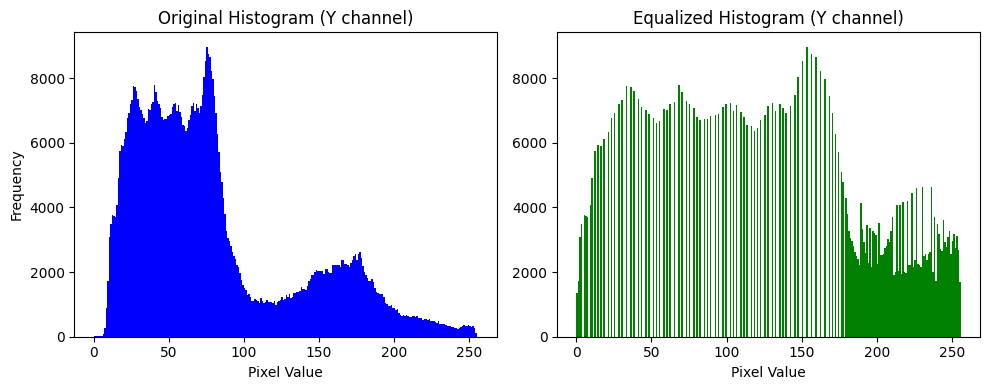


0: 640x288 1 Sprouted Potato, 551.5ms
Speed: 9.8ms preprocess, 551.5ms inference, 10.4ms postprocess per image at shape (1, 3, 640, 288)


In [9]:
def detect_and_annotate_potato(image_path, model_path="my_model.pt", confidence_threshold=0.3):
    # Load YOLOv11 model
    model = YOLO(model_path)

    # Load original image
    image = cv2.imread(image_path)

    # Convert image to YCrCb color space
    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    # Split the channels
    y, cr, cb = cv2.split(ycrcb)

    # Histogram equalization only on the Y (luminance) channel
    y_eq = cv2.equalizeHist(y)

    # Merge back the equalized Y with original Cr and Cb
    ycrcb_eq = cv2.merge([y_eq, cr, cb])

    # Convert back to BGR
    equalized_image = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

    # Plot histograms
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title("Original Histogram (Y channel)")
    plt.hist(y.ravel(), 256, [0, 256], color='blue')
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.title("Equalized Histogram (Y channel)")
    plt.hist(y_eq.ravel(), 256, [0, 256], color='green')
    plt.xlabel("Pixel Value")

    plt.tight_layout()
    plt.show()

    # Run YOLOv11 model on the equalized color image
    results = model.predict(source=equalized_image, conf=confidence_threshold, show=True,  imgsz=640)

    # Colors for class labels
    class_colors = {
        'Damaged Potato': (0, 0, 255),
        'Defected Potato': (255, 0, 0),
        'Potato': (0, 255, 0),
        'Sprouted Potato': (255, 255, 0)
    }
    # Font and color settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    font_thickness = 2

    # Draw bounding boxes and labels
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])       # Bounding box coordinates
            cls_id = int(box.cls[0])                     # Class ID
            conf = float(box.conf[0])                    # Confidence score
            label_name = model.names[cls_id]             # Class name (e.g., 'Potato')
            label = f"{label_name} ({conf:.2f})"         # Label text
            color = class_colors.get(label_name, (255, 255, 255))  # Color for the class

            # Draw bounding box
            cv2.rectangle(equalized_image, (x1, y1), (x2, y2), color, thickness=2)

            # Calculate label size and position
            (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
            label_rect_top_left = (x1, y1 - text_height - 10)
            label_rect_bottom_right = (x1 + text_width, y1)

            # Draw label background and text
            cv2.rectangle(equalized_image, label_rect_top_left, label_rect_bottom_right, color, -1)
            cv2.putText(equalized_image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)


    # Resize and show
    resized_image = cv2.resize(equalized_image, dsize=(640, 640), interpolation=cv2.INTER_NEAREST)
    cv2.imshow("Potato Detection on Equalized Image", resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

detect_and_annotate_potato("images/photo_2025-04-25_16-52-15.jpg")


In [8]:
def detect_and_annotate_potato(image_path, model_path="my_model.pt", confidence_threshold=0.2,):
    # Load the YOLOv11 model
    model = YOLO(model_path)
    # Load and read the image
    image = cv2.imread(image_path)
    # run YOLOv11 model on the image without preprocessing
    results = model.predict(source=image, conf=confidence_threshold, visualize=True, show=False,  imgsz=640)
    
    # Define colors for class labels
    class_colors = {
        'Damaged Potato': (0, 0, 255),
        'Defected Potato': (255, 0, 0),
        'Potato': (0, 255, 0),
        'Sprouted Potato': (255, 255, 0)
    }
    # Font and color settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    thickness_font = 2
    thickness = 2

    # Draw bounding boxes and labels
    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cls_id = int(box.cls[0])
            conf = float(box.conf[0])
            label_name = model.names[cls_id]
            label = f"{label_name} ({conf:.2f})"
            color = class_colors.get(label_name, (255, 255, 255))
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
            (text_w, text_h), _ = cv2.getTextSize(label, font, font_scale, thickness)
            cv2.rectangle(image, (x1, y1 - text_h - 10), (x1 + text_w, y1), color)
            cv2.putText(image, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), thickness_font)

    # Resize and show the image
    resized_image = cv2.resize(image, dsize=(640, 640), interpolation=cv2.INTER_NEAREST)
    cv2.imshow("Potato Detection", resized_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

detect_and_annotate_potato("images/test3.jpg")


Saving runs\detect\predict\image0\stage0_Conv_features.png... (32/32)
Saving runs\detect\predict\image0\stage1_Conv_features.png... (32/64)
Saving runs\detect\predict\image0\stage2_C3k2_features.png... (32/128)
Saving runs\detect\predict\image0\stage3_Conv_features.png... (32/128)
Saving runs\detect\predict\image0\stage4_C3k2_features.png... (32/256)
Saving runs\detect\predict\image0\stage5_Conv_features.png... (32/256)
Saving runs\detect\predict\image0\stage6_C3k2_features.png... (32/256)
Saving runs\detect\predict\image0\stage7_Conv_features.png... (32/512)
Saving runs\detect\predict\image0\stage8_C3k2_features.png... (32/512)
Saving runs\detect\predict\image0\stage9_SPPF_features.png... (32/512)
Saving runs\detect\predict\image0\stage10_C2PSA_features.png... (32/512)
Saving runs\detect\predict\image0\stage11_Upsample_features.png... (32/512)
Saving runs\detect\predict\image0\stage12_Concat_features.png... (32/768)
Saving runs\detect\predict\image0\stage13_C3k2_features.png... (32/2

In [7]:
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np

def detect_and_annotate_potato_realtime(model_path="my_model.pt", visualize =True ,confidence_threshold=0.3):
    # Load YOLOv11 model
    model = YOLO(model_path)

    # Initialize video capture (default camera)
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open camera.")
        return

    # Colors for class labels
    class_colors = {
        'Damaged Potato': (0, 0, 255),
        'Defected Potato': (255, 0, 0),
        'Potato': (0, 255, 0),
        'Sprouted Potato': (255, 255, 0)
    }
    # Font and color settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 2

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break

        # Convert frame to YCrCb color space
        ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)

        # Split the channels
        y, cr, cb = cv2.split(ycrcb)

        # Histogram equalization only on the Y (luminance) channel
        y_eq = cv2.equalizeHist(y)

        # Merge back the equalized Y with original Cr and Cb
        ycrcb_eq = cv2.merge([y_eq, cr, cb])

        # Convert back to BGR
        equalized_frame = cv2.cvtColor(ycrcb_eq, cv2.COLOR_YCrCb2BGR)

        # Run YOLOv11 model on the equalized frame
        results = model.predict(source=equalized_frame, conf=confidence_threshold, imgsz=640, verbose=False)

        # Draw bounding boxes and labels
        for r in results:
            for box in r.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])       # Bounding box coordinates
                cls_id = int(box.cls[0])                     # Class ID
                conf = float(box.conf[0])                    # Confidence score
                label_name = model.names[cls_id]             # Class name (e.g., 'Potato')
                label = f"{label_name} ({conf:.2f})"         # Label text
                color = class_colors.get(label_name, (255, 255, 255))  # Color for the class

                # Draw bounding box
                cv2.rectangle(equalized_frame, (x1, y1), (x2, y2), color, thickness=2)

                # Calculate label size and position
                (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale, font_thickness)
                label_rect_top_left = (x1, y1 - text_height - 10)
                label_rect_bottom_right = (x1 + text_width, y1)

                # Draw label background and text
                cv2.rectangle(equalized_frame, label_rect_top_left, label_rect_bottom_right, color, -1)
                cv2.putText(equalized_frame, label, (x1, y1 - 5), font, font_scale, (255, 255, 255), font_thickness)

        # Resize frame for display
        resized_frame = cv2.resize(equalized_frame, dsize=(640, 640), interpolation=cv2.INTER_NEAREST)

        # Display the frame
        cv2.imshow("Real-Time Potato Detection", resized_frame)

        # Break loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release resources
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    detect_and_annotate_potato_realtime()